# CS260 Final Project<br>

### Loading dependencies

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install pycocotools
! pip install scikit-image
! pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 538 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hpglu058
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hpglu058
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=173b0c906289f40ec299484a7ceb96ccabc1cb337ea9d4496438c32649a22e4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vtxh1zyt/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [76]:
import numpy as np
import pandas as pd
import torch
from pkg_resources import packaging
import clip
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image 
import urllib.request
from numpy.linalg import norm
import seaborn as sns
import time

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Dataset

In [3]:
img_vec = torch.load('/content/drive/MyDrive/260 Final/image_feature_50000.pt', map_location=torch.device('cpu'))
txt_vec = torch.load('/content/drive/MyDrive/260 Final/text_feature_50000.pt', map_location=torch.device('cpu'))

img_test = torch.load('/content/drive/MyDrive/260 Final/image_features_test2000.pt', map_location=torch.device('cpu'))
txt_test = torch.load('/content/drive/MyDrive/260 Final/text_features_test2000.pt', map_location=torch.device('cpu'))

annFile = "/content/drive/MyDrive/260 Final/captions_train2014.json"

### Bag of Words

In [4]:
def bag_of_words(res_ann, input_ann):
  res = []
  input_ann = input_ann.replace('.', "")
  input_ann = input_ann.replace(',', "")
  y = input_ann.split(" ")
  for strs in res_ann:
    dict = {}
    dup = 0
    strs = strs.replace(',', "")
    strs = strs.replace('.', "")
    x = strs.split(" ")
    l = len(x) + len(y)
    for words in x:
      words = words.lower()
      dict[words] = dict.get(words, 0) + 1
    for words in y:
      words = words.lower()
      if (words in dict and dict.get(words) > 0):
        dict[words] = dict.get(words) - 1
        dup+=1
    res.append(dup / (l - dup))
  return res

### Cosine Similarity

In [5]:
def cosine_sim(A, B):
  A = np.squeeze(np.asarray(A))
  B = np.squeeze(np.asarray(B))
  return np.dot(A,B)/(norm(A)*norm(B))

### Faiss L2-Norm Search

In [13]:
import faiss

index = faiss.IndexFlatL2(img_vec.shape[1])
index.add(img_vec)

image_vec1 = img_test.cpu().numpy()
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!


### Nearest Neighbor

In [102]:
t1 = time.perf_counter()

k = 1
cosine_similarity_nn = []
jaccard_score_nn = []
cnt = 0

for x in range(2000):
  temp = image_vec1[x].reshape(1,512)

  input_img = coco.loadImgs(imgIds)[60000+x]
  input_annIds = coco.getAnnIds(imgIds=input_img['id'])
  input_anns = coco.loadAnns(input_annIds)[0]['caption']

  D, I =index.search(temp,k)
  res_ann = []
  curr_cos = []

  for i in range(k):
    img = coco.loadImgs(imgIds)[I[0][i]]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    res_ann.append(anns[0]['caption'])
    curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

  curr_jaccard = bag_of_words(res_ann, input_anns)

  for x in curr_cos:
    cosine_similarity_nn.append(x)

  for x in curr_jaccard:
    jaccard_score_nn.append(x)
  
  cnt+=1
  if (cnt % 100 == 0): print("Processing: ",cnt)
t2 = time.perf_counter()
print('\ntime taken to run:',t2-t1)
print('\nmean_cosine_similarity: ', np.mean(cosine_similarity_nn))
print('mean_jaccard_score: ', np.mean(jaccard_score_nn))

Processing:  100
Processing:  200
Processing:  300
Processing:  400
Processing:  500
Processing:  600
Processing:  700
Processing:  800
Processing:  900
Processing:  1000
Processing:  1100
Processing:  1200
Processing:  1300
Processing:  1400
Processing:  1500
Processing:  1600
Processing:  1700
Processing:  1800
Processing:  1900
Processing:  2000

time taken to run: 65.15108175900059

mean_cosine_similarity:  0.8411817
mean_jaccard_score:  0.18645865499883604


### Nearest Neighbor Distribution

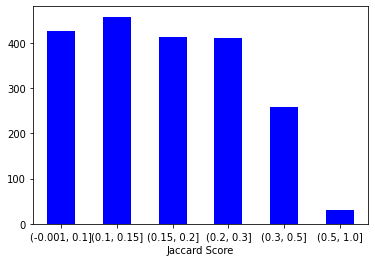

In [103]:
out = pd.cut(jaccard_score_nn, bins=[0.0, 0.1, 0.15, 0.2, 0.3, 0.5, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Jaccard Score")
plt.show()

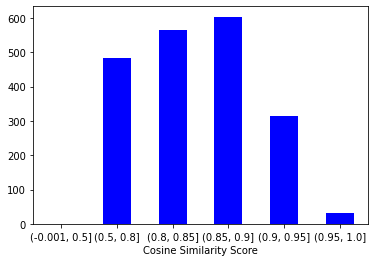

In [104]:
plt_idx = ['0.0-0.5','0.5-0.8','0.8-0.85','0.85-0.9','0.9-0.95','0.95-1']
out = pd.cut(cosine_similarity_nn, bins=[0.0, 0.5, 0.8, 0.85, 0.9, 0.95, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Cosine Similarity Score")
plt.show()

### K-Nearest Neighbor

#### 3-NN

In [105]:
t1 = time.perf_counter()

k = 3
cosine_similarity_nn = []
jaccard_score_nn = []
cnt = 0

for x in range(2000):
  temp = image_vec1[x].reshape(1,512)

  input_img = coco.loadImgs(imgIds)[60000+x]
  input_annIds = coco.getAnnIds(imgIds=input_img['id'])
  input_anns = coco.loadAnns(input_annIds)[0]['caption']

  D, I =index.search(temp,k)
  res_ann = []
  curr_cos = []

  for i in range(k):
    img = coco.loadImgs(imgIds)[I[0][i]]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    res_ann.append(anns[0]['caption'])
    curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

  curr_jaccard = bag_of_words(res_ann, input_anns)

  for x in curr_cos:
    cosine_similarity_nn.append(x)

  for x in curr_jaccard:
    jaccard_score_nn.append(x)
  
  cnt+=1
  if (cnt % 100 == 0): print("Processing: ",cnt)
t2 = time.perf_counter()
print('time taken to run:',t2-t1)
print('\nmean_cosine_similarity: ', np.mean(cosine_similarity_nn))
print('mean_jaccard_score: ', np.mean(jaccard_score_nn))

Processing:  100
Processing:  200
Processing:  300
Processing:  400
Processing:  500
Processing:  600
Processing:  700
Processing:  800
Processing:  900
Processing:  1000
Processing:  1100
Processing:  1200
Processing:  1300
Processing:  1400
Processing:  1500
Processing:  1600
Processing:  1700
Processing:  1800
Processing:  1900
Processing:  2000
time taken to run: 103.38671956500002

mean_cosine_similarity:  0.8308584
mean_jaccard_score:  0.18575951498588703


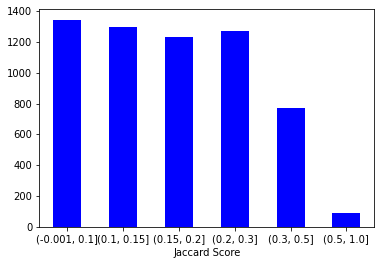

In [106]:
out = pd.cut(jaccard_score_nn, bins=[0.0, 0.1, 0.15, 0.2, 0.3, 0.5, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Jaccard Score")
plt.show()

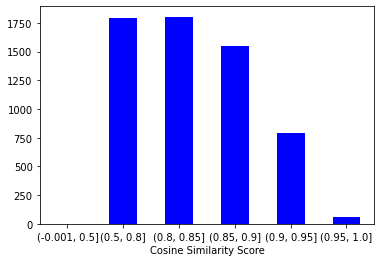

In [107]:
plt_idx = ['0.0-0.5','0.5-0.8','0.8-0.85','0.85-0.9','0.9-0.95','0.95-1']
out = pd.cut(cosine_similarity_nn, bins=[0.0, 0.5, 0.8, 0.85, 0.9, 0.95, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Cosine Similarity Score")
plt.show()

#### 6-NN

In [109]:
t1 = time.perf_counter()

k = 6
cosine_similarity_nn = []
jaccard_score_nn = []
cnt = 0

for x in range(2000):
  temp = image_vec1[x].reshape(1,512)

  input_img = coco.loadImgs(imgIds)[60000+x]
  input_annIds = coco.getAnnIds(imgIds=input_img['id'])
  input_anns = coco.loadAnns(input_annIds)[0]['caption']

  D, I =index.search(temp,k)
  res_ann = []
  curr_cos = []

  for i in range(k):
    img = coco.loadImgs(imgIds)[I[0][i]]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    res_ann.append(anns[0]['caption'])
    curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

  curr_jaccard = bag_of_words(res_ann, input_anns)

  for x in curr_cos:
    cosine_similarity_nn.append(x)

  for x in curr_jaccard:
    jaccard_score_nn.append(x)
  
  cnt+=1
  if (cnt % 100 == 0): print("Processing: ",cnt)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)
print('\nmean_cosine_similarity: ', np.mean(cosine_similarity_nn))
print('mean_jaccard_score: ', np.mean(jaccard_score_nn))

Processing:  100
Processing:  200
Processing:  300
Processing:  400
Processing:  500
Processing:  600
Processing:  700
Processing:  800
Processing:  900
Processing:  1000
Processing:  1100
Processing:  1200
Processing:  1300
Processing:  1400
Processing:  1500
Processing:  1600
Processing:  1700
Processing:  1800
Processing:  1900
Processing:  2000
time taken to run: 169.0848730050002

mean_cosine_similarity:  0.8221273
mean_jaccard_score:  0.1832946056521004


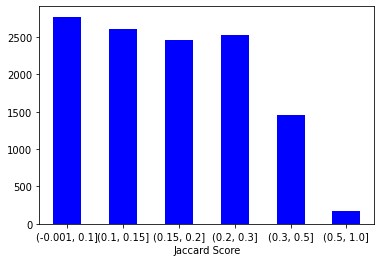

In [110]:
out = pd.cut(jaccard_score_nn, bins=[0.0, 0.1, 0.15, 0.2, 0.3, 0.5, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Jaccard Score")
plt.show()

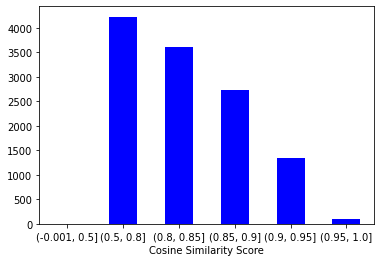

In [111]:
plt_idx = ['0.0-0.5','0.5-0.8','0.8-0.85','0.85-0.9','0.9-0.95','0.95-1']
out = pd.cut(cosine_similarity_nn, bins=[0.0, 0.5, 0.8, 0.85, 0.9, 0.95, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Cosine Similarity Score")
plt.show()

#### 10-NN

In [112]:
t1 = time.perf_counter()

k = 10
cosine_similarity_nn = []
jaccard_score_nn = []
cnt = 0

for x in range(2000):
  temp = image_vec1[x].reshape(1,512)

  input_img = coco.loadImgs(imgIds)[60000+x]
  input_annIds = coco.getAnnIds(imgIds=input_img['id'])
  input_anns = coco.loadAnns(input_annIds)[0]['caption']

  D, I =index.search(temp,k)
  res_ann = []
  curr_cos = []

  for i in range(k):
    img = coco.loadImgs(imgIds)[I[0][i]]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    res_ann.append(anns[0]['caption'])
    curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

  curr_jaccard = bag_of_words(res_ann, input_anns)

  for x in curr_cos:
    cosine_similarity_nn.append(x)

  for x in curr_jaccard:
    jaccard_score_nn.append(x)
  
  cnt+=1
  if (cnt % 100 == 0): print("Processing: ",cnt)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)
print('\nmean_cosine_similarity: ', np.mean(cosine_similarity_nn))
print('mean_jaccard_score: ', np.mean(jaccard_score_nn))

Processing:  100
Processing:  200
Processing:  300
Processing:  400
Processing:  500
Processing:  600
Processing:  700
Processing:  800
Processing:  900
Processing:  1000
Processing:  1100
Processing:  1200
Processing:  1300
Processing:  1400
Processing:  1500
Processing:  1600
Processing:  1700
Processing:  1800
Processing:  1900
Processing:  2000
time taken to run: 249.02178302099946

mean_cosine_similarity:  0.8147865
mean_jaccard_score:  0.18003233084066605


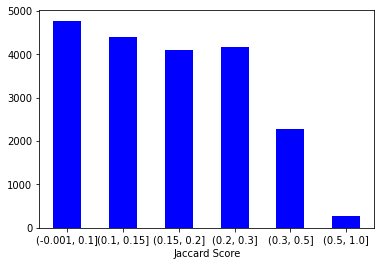

In [113]:
out = pd.cut(jaccard_score_nn, bins=[0.0, 0.1, 0.15, 0.2, 0.3, 0.5, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Jaccard Score")
plt.show()

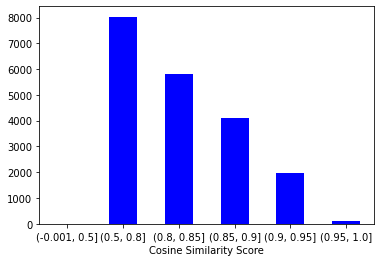

In [114]:
plt_idx = ['0.0-0.5','0.5-0.8','0.8-0.85','0.85-0.9','0.9-0.95','0.95-1']
out = pd.cut(cosine_similarity_nn, bins=[0.0, 0.5, 0.8, 0.85, 0.9, 0.95, 1], include_lowest=True)
df = pd.Series(out)
ax = df.value_counts(sort=False).plot.bar(rot=0, color="b")
plt.xlabel("Cosine Similarity Score")
plt.show()

#### Human Evaluation


 INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT 



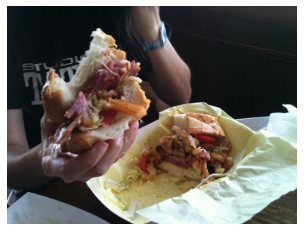

A large pastrami sandwich sitting on a table.

 OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT 



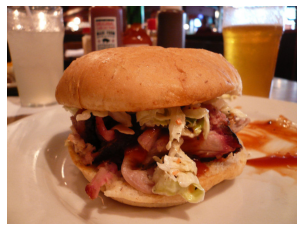

A pork sandwich on a roll with slaw on a plate with a glass of beer behind.


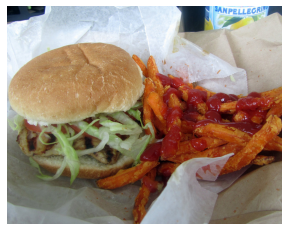

A grilled chicken burger and ketchup covered fries on takeout paper


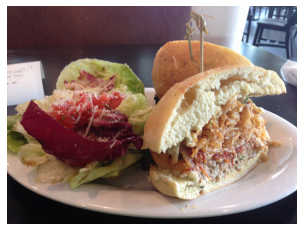

A white plate with a sandwich and salad on it.

cosine:  [0.8424332, 0.84319615, 0.83494616]
jaccard:  [0.19047619047619047, 0.11764705882352941, 0.2857142857142857]

cosine_mean:  0.84019184
jaccard_mean:  0.19794584500466852


In [97]:
k = 3
cnt = 0

temp = image_vec1[0].reshape(1,512)

print("\n INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT \n")
input_img = coco.loadImgs(imgIds)[60000]
I = io.imread(input_img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
input_annIds = coco.getAnnIds(imgIds=input_img['id'])
input_anns = coco.loadAnns(input_annIds)[0]['caption']
print(input_anns)

print("\n OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT \n")
D, I =index.search(temp,k)
res_ann = []
curr_cos = []

for i in range(k):
  img = coco.loadImgs(imgIds)[I[0][i]]
  tmp = io.imread(img['coco_url'])
  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  plt.axis('off')
  plt.imshow(tmp)
  plt.show()
  res_ann.append(anns[0]['caption'])
  print(anns[0]['caption'])
  curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

curr_jaccard = bag_of_words(res_ann, input_anns)
print("\ncosine: ", curr_cos)
print("jaccard: ",curr_jaccard)

print("\ncosine_mean: ", np.mean(curr_cos))
print("jaccard_mean: ", np.mean(curr_jaccard))


 INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT 



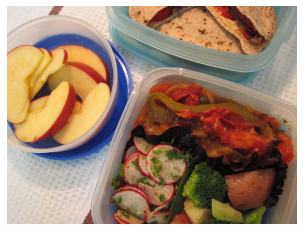

Three bowls of food containing apples, broccoli and potatoes.

 OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT 



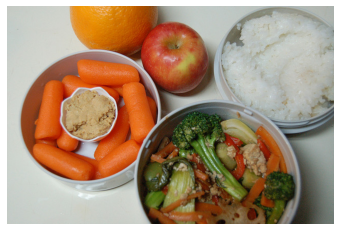

Little tubs of rice and mixed vegetables for a meal


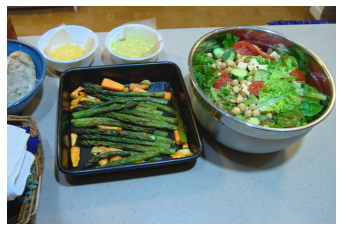

Cooked asparagus and a green salad with cucumbers, tomatoes and chick peas.


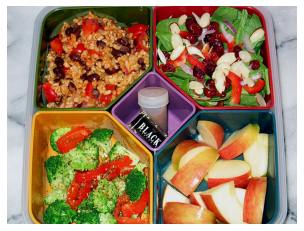

A bunch of plastic containers filled with fruits and vegetables

cosine:  [0.85172975, 0.84496135, 0.834546]
jaccard:  [0.11764705882352941, 0.05, 0.11764705882352941]

cosine_mean:  0.8437457
jaccard_mean:  0.09509803921568627


In [98]:
k = 3
cnt = 0

temp = image_vec1[1000].reshape(1,512)

print("\n INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT \n")
input_img = coco.loadImgs(imgIds)[61000]
I = io.imread(input_img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
input_annIds = coco.getAnnIds(imgIds=input_img['id'])
input_anns = coco.loadAnns(input_annIds)[0]['caption']
print(input_anns)

print("\n OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT \n")
D, I =index.search(temp,k)
res_ann = []
curr_cos = []

for i in range(k):
  img = coco.loadImgs(imgIds)[I[0][i]]
  tmp = io.imread(img['coco_url'])
  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  plt.axis('off')
  plt.imshow(tmp)
  plt.show()
  res_ann.append(anns[0]['caption'])
  print(anns[0]['caption'])
  curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

curr_jaccard = bag_of_words(res_ann, input_anns)
print("\ncosine: ", curr_cos)
print("jaccard: ",curr_jaccard)

print("\ncosine_mean: ", np.mean(curr_cos))
print("jaccard_mean: ", np.mean(curr_jaccard))


 INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT 



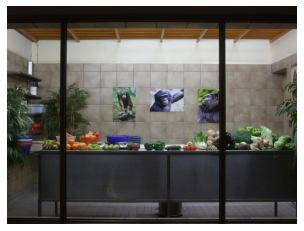

A counter with various vegetables on it with pictures hanging behind it.

 OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT 



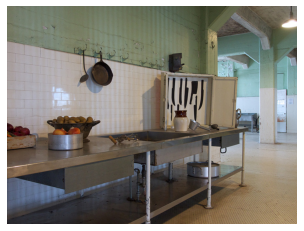

A large kitchen has a stainless steel counter.


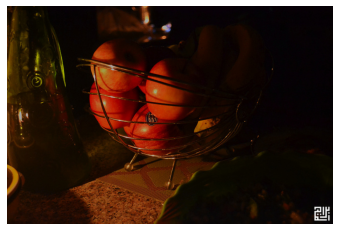

Oranges sit together in a bowl in the light. 


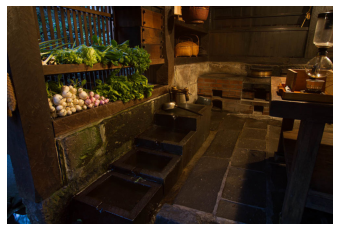

a dark room with some kind of vegetables in the window

cosine:  [0.7561072, 0.7645561, 0.7432224]
jaccard:  [0.1111111111111111, 0.047619047619047616, 0.15]

cosine_mean:  0.7546286
jaccard_mean:  0.10291005291005291


In [99]:
k = 3
cnt = 0

temp = image_vec1[1500].reshape(1,512)

print("\n INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT \n")
input_img = coco.loadImgs(imgIds)[61500]
I = io.imread(input_img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
input_annIds = coco.getAnnIds(imgIds=input_img['id'])
input_anns = coco.loadAnns(input_annIds)[0]['caption']
print(input_anns)

print("\n OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT \n")
D, I =index.search(temp,k)
res_ann = []
curr_cos = []

for i in range(k):
  img = coco.loadImgs(imgIds)[I[0][i]]
  tmp = io.imread(img['coco_url'])
  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  plt.axis('off')
  plt.imshow(tmp)
  plt.show()
  res_ann.append(anns[0]['caption'])
  print(anns[0]['caption'])
  curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

curr_jaccard = bag_of_words(res_ann, input_anns)
print("\ncosine: ", curr_cos)
print("jaccard: ",curr_jaccard)

print("\ncosine_mean: ", np.mean(curr_cos))
print("jaccard_mean: ", np.mean(curr_jaccard))


 INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT 



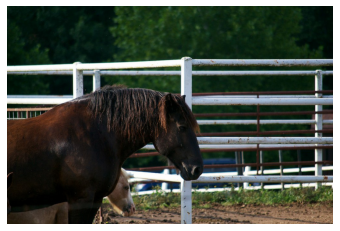

A horse is standing inside a pen next to a smaller horse.

 OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT 



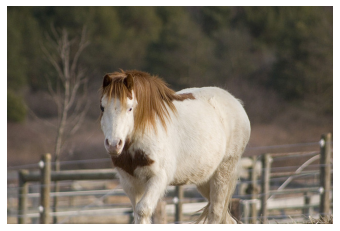

A brown and white horse walking behind a wooden fence.


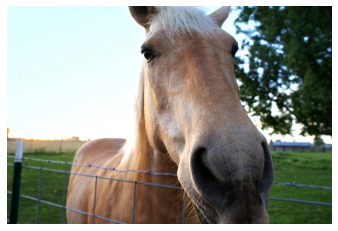

A horse on a ranch with lots of grass.


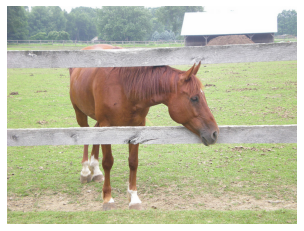

A horse is standing in the grass with its head in a fence.

cosine:  [0.8772303, 0.8752577, 0.86306447]
jaccard:  [0.15789473684210525, 0.16666666666666666, 0.25]

cosine_mean:  0.8718508
jaccard_mean:  0.1915204678362573


In [101]:
k = 3
cnt = 0

temp = image_vec1[1999].reshape(1,512)

print("\n INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT \n")
input_img = coco.loadImgs(imgIds)[61999]
I = io.imread(input_img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
input_annIds = coco.getAnnIds(imgIds=input_img['id'])
input_anns = coco.loadAnns(input_annIds)[0]['caption']
print(input_anns)

print("\n OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT \n")
D, I =index.search(temp,k)
res_ann = []
curr_cos = []

for i in range(k):
  img = coco.loadImgs(imgIds)[I[0][i]]
  tmp = io.imread(img['coco_url'])
  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  plt.axis('off')
  plt.imshow(tmp)
  plt.show()
  res_ann.append(anns[0]['caption'])
  print(anns[0]['caption'])
  curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

curr_jaccard = bag_of_words(res_ann, input_anns)
print("\ncosine: ", curr_cos)
print("jaccard: ",curr_jaccard)

print("\ncosine_mean: ", np.mean(curr_cos))
print("jaccard_mean: ", np.mean(curr_jaccard))


 INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT 



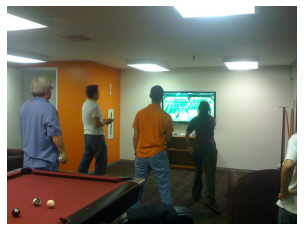

A group of people in a recreational room playing game with Nintendo Wii controllers.

 OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT 



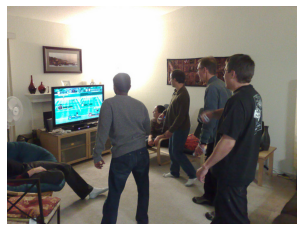

A group of adults standing in a living room playing a video game.


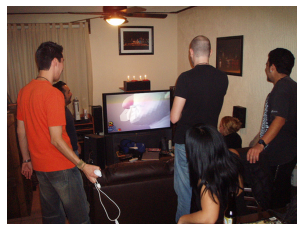

Multiple people gathered around a television playing a video game. 


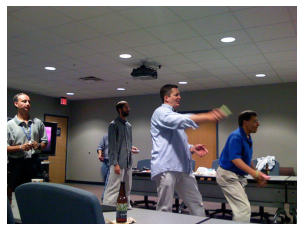

People playing Nintendo Wii at the office for fun.

cosine:  [0.78257257, 0.76522, 0.72861844]
jaccard:  [0.42105263157894735, 0.25, 0.21052631578947367]

cosine_mean:  0.75880367
jaccard_mean:  0.293859649122807


In [116]:
k = 3
cnt = 0

temp = image_vec1[1234].reshape(1,512)

print("\n INPUT  ----- INPUT ----- INPUT ----- INPUT ----- INPUT \n")
input_img = coco.loadImgs(imgIds)[61234]
I = io.imread(input_img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()
input_annIds = coco.getAnnIds(imgIds=input_img['id'])
input_anns = coco.loadAnns(input_annIds)[0]['caption']
print(input_anns)

print("\n OUTPUT  ----- OUTPUT ----- OUTPUT ----- OUTPUT ----- OUTPUT \n")
D, I =index.search(temp,k)
res_ann = []
curr_cos = []

for i in range(k):
  img = coco.loadImgs(imgIds)[I[0][i]]
  tmp = io.imread(img['coco_url'])
  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  plt.axis('off')
  plt.imshow(tmp)
  plt.show()
  res_ann.append(anns[0]['caption'])
  print(anns[0]['caption'])
  curr_cos.append(cosine_sim(img_vec[I[0][i]].reshape(1,512), temp))

curr_jaccard = bag_of_words(res_ann, input_anns)
print("\ncosine: ", curr_cos)
print("jaccard: ",curr_jaccard)

print("\ncosine_mean: ", np.mean(curr_cos))
print("jaccard_mean: ", np.mean(curr_jaccard))